In [2]:
# @title 1. Install Dependencies
# We use 'wandb' for the leaderboard, 'thop' for counting FLOPs, and 'torchview' for graphs.
# !pip install wandb thop torchview captum -qU
# !apt-get install graphviz -y -q

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchview import draw_graph
from thop import profile
import wandb
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import GuidedGradCam

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.025633544..1.0063382].


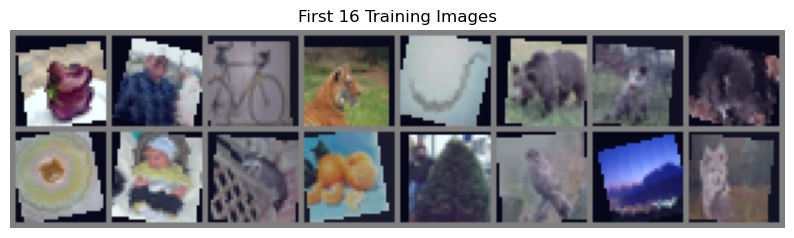

In [6]:
# @title 2. Load and Visualize Data
# Preprocessing: Standard CIFAR-100 normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    # --- 新增增强 ---
    transforms.RandomRotation(15),  # 随机旋转 +/- 15度
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # 随机调整颜色
    # ----------------
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# VISUALIZATION FUNCTION
def imshow(img, title):
    img = img * 0.25 + 0.5     # unnormalize roughly for display
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images locally
imshow(torchvision.utils.make_grid(images[:16]), "First 16 Training Images")

Generating Architecture Graph on CPU...


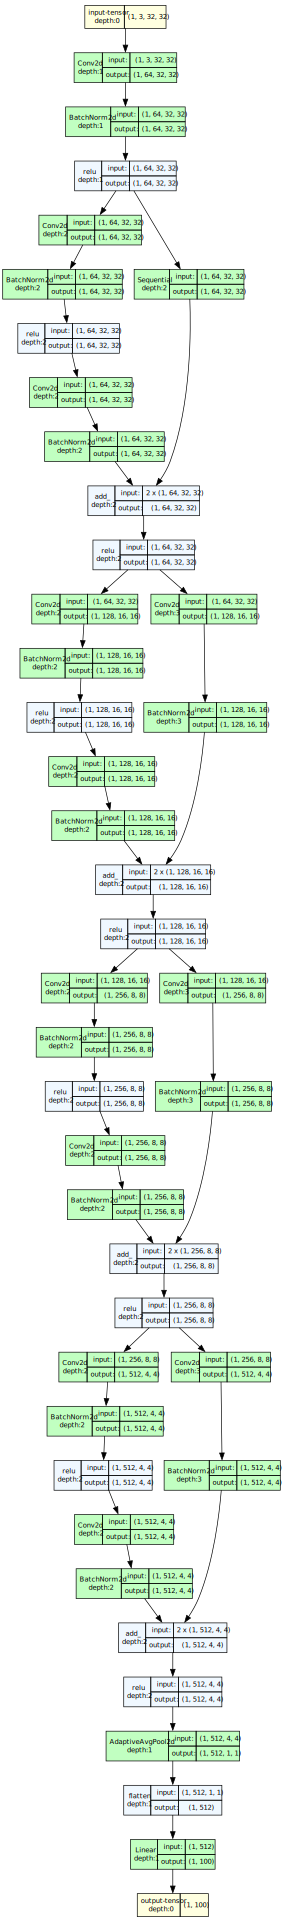

In [7]:
# @title 3. Design Your "Efficient" CNN
import torch.nn.functional as F

# 定义一个基本的残差块 (Residual Block)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # 卷积层 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 卷积层 2
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut (跳跃连接) 处理
        # 如果输入输出维度不一样（比如 stride=2 或者通道数变了），shortcut 也需要用 1x1 卷积调整
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # 核心：加入残差 (x + F(x))
        out = F.relu(out)
        return out

class StudentModel(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        # 初始层：RGB -> 64通道
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 堆叠残差层 (这里设计为 3 个阶段，每个阶段通道数翻倍)
        # Stage 1: 64 -> 64 (保持尺寸 32x32)
        self.layer1 = self._make_layer(64, 64, stride=1)
        # Stage 2: 64 -> 128 (尺寸变为 16x16)
        self.layer2 = self._make_layer(64, 128, stride=2)
        # Stage 3: 128 -> 256 (尺寸变为 8x8)
        self.layer3 = self._make_layer(128, 256, stride=2)
        # Stage 4: 256 -> 512 (尺寸变为 4x4) - 可选，为了更高精度加深这一层
        self.layer4 = self._make_layer(256, 512, stride=2)

        # 全局平均池化 + 分类器
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, num_classes) # 注意输入是 512

    def _make_layer(self, in_channels, out_channels, stride):
        return ResidualBlock(in_channels, out_channels, stride)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out) # 如果你觉得训练太慢，可以注释掉 layer4 并把 classifier 改为 256
        
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StudentModel().to(device)

# --- LOCAL GRAPH VISUALIZATION ---
from IPython.display import display
from torchview import draw_graph

# 1. 先把模型放到 CPU
model_cpu = StudentModel().to("cpu")

# 2. 用 CPU 模式生成图
print("Generating Architecture Graph on CPU...")
try:
    model_graph = draw_graph(model_cpu, input_size=(1, 3, 32, 32), device="cpu")
    display(model_graph.visual_graph)
except Exception as e:
    print(f"画图出错 (不影响训练): {e}")

# 3. 画完图后，再把模型放回 GPU
model = model_cpu.to(device)

In [ ]:
# @title 4. Train & Upload to Leaderboard
# 1. Login to W&B (You will be asked for API Key once)
wandb.login()

# 2. Configuration
# ENTITY_NAME = "adam-bone50-the-hong-kong-polytechnic-university"
PROJECT_NAME = "CIFAR100-Class-Competition" # Teacher: Change this
RUN_NAME = "ZhaoKangzhe_V1"               # Student: Change this

wandb.init(
    # entity=ENTITY_NAME,
    project=PROJECT_NAME,
    name=RUN_NAME,
    config={
        "learning_rate": 0.001,
        "epochs": 10,
        "batch_size": 128,
        "optimizer": "Adam"
    }
)
config = wandb.config

# 3. Calculate FLOPs (Efficiency Score)
input_dummy = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(input_dummy,), verbose=False)
print(f"Model FLOPs: {flops/1e6:.2f}M | Params: {params/1e6:.2f}M")
wandb.log({"Complexity/FLOPs": flops, "Complexity/Params": params})

# 4. Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

print("Starting Training...")
for epoch in range(config.epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    avg_loss = running_loss / len(trainloader)

    # --- LOGGING TO LEADERBOARD ---
    wandb.log({
        "Performance/Accuracy": acc,
        "Performance/Loss": avg_loss,
        "Epoch": epoch
    })
    print(f"Epoch {epoch+1}: Loss {avg_loss:.3f} | Accuracy {acc:.2%}")

print("Training Complete. Check the W&B Dashboard!")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Complexity/FLOPs,▁
Complexity/Params,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Performance/Accuracy,▁▃▄▅▆▆▇███
Performance/Loss,█▅▄▃▃▂▂▂▁▁
Complexity/FLOPs,61121792.0
Complexity/Params,479716
Epoch,9
Performance/Accuracy,0.4593
Performance/Loss,1.87178


Model FLOPs: 254.96M | Params: 4.95M
Starting Training...
Epoch 1: Loss 3.723 | Accuracy 20.85%
Epoch 2: Loss 2.991 | Accuracy 27.26%
Epoch 3: Loss 2.536 | Accuracy 36.84%
Epoch 4: Loss 2.237 | Accuracy 39.23%
Epoch 5: Loss 2.009 | Accuracy 45.09%
Epoch 6: Loss 1.843 | Accuracy 46.56%
Epoch 7: Loss 1.692 | Accuracy 52.41%
Epoch 8: Loss 1.574 | Accuracy 55.01%
Epoch 9: Loss 1.464 | Accuracy 56.66%
Epoch 10: Loss 1.376 | Accuracy 56.53%
Training Complete. Check the W&B Dashboard!


解释的目标层级: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


c:\Apps\miniconda3\envs\ds_study\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:63: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
c:\Apps\miniconda3\envs\ds_study\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


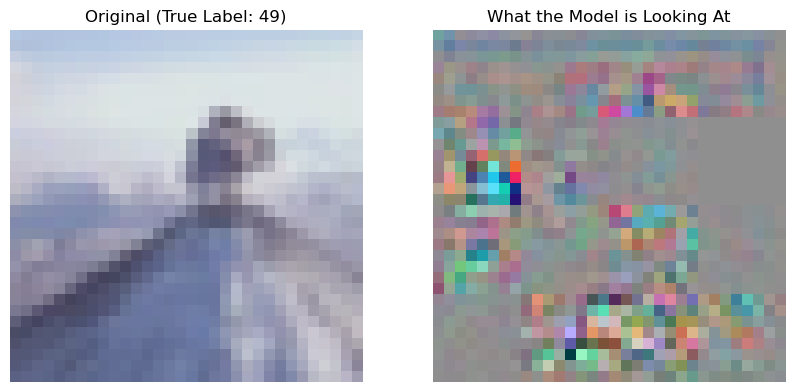

In [12]:
# @title 5. "Why did the model predict that?" (Grad-CAM)
from captum.attr import GuidedGradCam
import numpy as np
import matplotlib.pyplot as plt

# 1. 准备数据
dataiter = iter(testloader)
images, labels = next(dataiter)
input_img = images[0:1].to(device)
true_label = labels[0].item()

model.eval()

# 2. 【修正点】定位目标层
# 因为你的 layer4 只有一个块，直接调用它的 conv2 即可，不需要加 [-1]
try:
    # 尝试访问 layer4 的第二个卷积层
    target_layer = model.layer4.conv2 
except AttributeError:
    # 如果为了加速你注释掉了 layer4，那就访问 layer3
    target_layer = model.layer3.conv2

print(f"解释的目标层级: {target_layer}")

# 3. 初始化 Grad-CAM
# 这一步会把梯度挂钩子到卷积层上
gc = GuidedGradCam(model, target_layer)

# 4. 计算 Attribution
# 注意：GuidedGradCam 计算量稍大，如果这一步显存不够，可以改用普通 GradCam
attribution = gc.attribute(input_img, target=true_label)

# 5. 可视化处理
attr_img = attribution.squeeze().cpu().detach().numpy()
attr_img = np.transpose(attr_img, (1, 2, 0))

# 归一化 (让图片亮度正常显示)
attr_img = (attr_img - attr_img.min()) / (attr_img.max() - attr_img.min())

# 6. 画图
plt.figure(figsize=(10, 5))

# 左边：原图
plt.subplot(1, 2, 1)
plt.title(f"Original (True Label: {true_label})")
# 反归一化显示原图
img_show = images[0].numpy() * 0.2 + 0.5 
plt.imshow(np.transpose(img_show, (1, 2, 0)))
plt.axis('off')

# 右边：AI 关注哪里
plt.subplot(1, 2, 2)
plt.title("What the Model is Looking At")
plt.imshow(attr_img)
plt.axis('off')

plt.show()